# Equatorial Upperocean model vs. obs comparison

The goal of this notebook is the following:

1) serve as an example of how to post-process CESM/MOM6 output;

2) create time averages of T, S and VEL fields and compared agains observations (PHC2 and Johnson et al, 2002);

/glade/p/cesm/omwg/obs_data/phc/PHC2_TEMP_tx0.66v1_34lev_ann_avg.nc

/glade/p/cesm/omwg/obs_data/phc/PHC2_SALT_tx0.66v1_34lev_ann_avg.nc

/glade/p/cesm/omwg/obs_data/johnson_pmel/meanfit_m.nc

TODO:
* Compare potential density plots;
* compare model results vs. another model results (TODO);


In [1]:
%matplotlib inline
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import shiftgrid
from mom6_tools.m6plot import yzcompare, yzplot
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools.ClimoGenerator import ClimoGenerator
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
import yaml
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import display, Markdown, Latex
import warnings
warnings.filterwarnings("ignore")

Basemap module not found. Some regional plots may not function properly


In [2]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [3]:
# Create the case instance
dcase = DiagsCase(diag_config_yml['Case'])
print('Casename is:', dcase.casename)

Casename is: g.c2b6.GJRA.TL319_t061.long_JRA_mct.002


In [4]:
# Load the grid
RUNDIR = dcase.get_value('RUNDIR')
grd = MOM6grid(RUNDIR+'/'+dcase.casename+'.mom6.static.nc', xrformat=True)
grd_eq = grd.sel(yh=slice(-10,10)) 

MOM6 grid successfully loaded... 



In [5]:
# Create the climatology instance
cluster = NCARCluster(project='P93300612')
cluster.scale(6)
cluster

In [6]:
client = Client(cluster)
print(cluster.dashboard_link)
client

https://jupyterhub.ucar.edu/dav/user/gmarques/proxy/44277/status


<Client: 'tcp://128.117.181.208:36556' processes=6 threads=6, memory=150.00 GB>

In [7]:
# Compute the climatology dataset
#dset_climo = climo.stage()
variables = ['thetao', 'so', 'uo', 'time', 'time_bnds', 'e']
RUNDIR = dcase.get_value('RUNDIR')

def preprocess(ds):
    ''' Compute yearly averages and return the dataset with variables'''
    return ds[variables].resample(time="1Y", closed='left', \
           keep_attrs=True).mean(dim='time', keep_attrs=True)

ds = xr.open_mfdataset(RUNDIR+'/'+dcase.casename+'.mom6.h_*.nc', \
         parallel=True, data_vars='minimal', \
         coords='minimal', compat='override', preprocess=preprocess)

In [8]:
# load obs 
phc_path = '/glade/p/cesm/omwg/obs_data/phc/'
phc_temp = xr.open_mfdataset(phc_path+'PHC2_TEMP_tx0.66v1_34lev_ann_avg.nc')#.sel(Y=slice(-10,10)) 
phc_salt = xr.open_mfdataset(phc_path+'PHC2_SALT_tx0.66v1_34lev_ann_avg.nc')#.sel(Y=slice(-10,10)) 
johnson = xr.open_dataset('/glade/p/cesm/omwg/obs_data/johnson_pmel/meanfit_m.nc')

In [9]:
# get theta and salt and rename coordinates to be the same as the model's
thetao_obs = phc_temp.TEMP.rename({'X': 'xh','Y': 'yh', 'depth': 'z_l'});
salt_obs = phc_salt.SALT.rename({'X': 'xh','Y': 'yh', 'depth': 'z_l'});

In [10]:
# set coordinates to the same as the model's
thetao_obs['xh'] = ds.xh; thetao_obs['yh'] = ds.yh;
salt_obs['xh'] = ds.xh; salt_obs['yh'] = ds.yh;

In [12]:
# select in space and time
start_date = '0001-01-01'
end_date = '0058-12-31'
%time ds = ds.sel(time=slice(start_date, end_date)).sel(yh=slice(-10,10)).isel(z_i=slice(0,15)).isel(z_l=slice(0,14))

CPU times: user 7.87 ms, sys: 950 µs, total: 8.82 ms
Wall time: 7.34 ms


In [13]:
print('Time averaging...')
thetao = ds.thetao.mean('time')
so = ds.so.mean('time')
uo = ds.uo.mean('time')
eta = ds.e.mean('time')

Time averaging...


In [14]:
print('Selecting equatorial data...')
# find point closest to eq. and select data
j = np.abs( grd_eq.geolat[:,0].values - 0. ).argmin()
temp_eq = np.ma.masked_invalid(thetao.isel(yh=j).values)
salt_eq = np.ma.masked_invalid(so.isel(yh=j).values)
u_eq    = np.ma.masked_invalid(uo.isel(yh=j).values)
e_eq    = np.ma.masked_invalid(eta.isel(yh=j).values)
thetao_obs_eq = np.ma.masked_invalid(thetao_obs.sel(yh=slice(-10,10)).isel(yh=j).isel(z_l=slice(0,14)).values)
salt_obs_eq = np.ma.masked_invalid(salt_obs.sel(yh=slice(-10,10)).isel(yh=j).isel(z_l=slice(0,14)).values)

Selecting equatorial data...


In [15]:
client.close(); cluster.close()

In [16]:
y = ds.yh.values
zz = ds.z_i.values
x = ds.xh.values
[X, Z] = np.meshgrid(x, zz)
z = 0.5 * ( Z[:-1] + Z[1:])

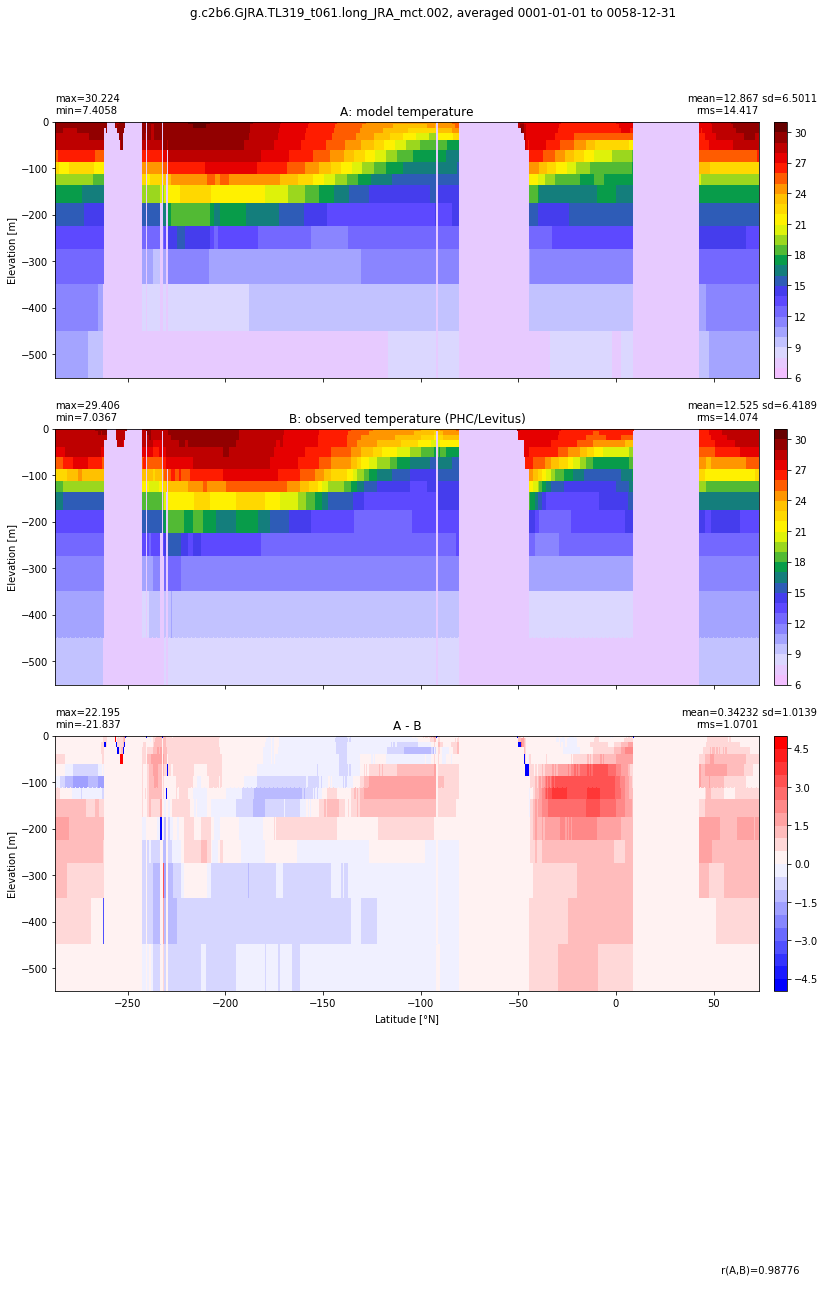

In [17]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,16))
yzcompare(temp_eq , thetao_obs_eq, x, -Z,
        title1 = 'model temperature',
        title2 = 'observed temperature (PHC/Levitus)', axis=ax,
        suptitle=dcase.casename + ', averaged '+str(start_date)+ ' to ' +str(end_date),
        extend='neither', dextend='neither', clim=(6,31.), dlim=(-5,5), dcolormap=plt.cm.bwr)

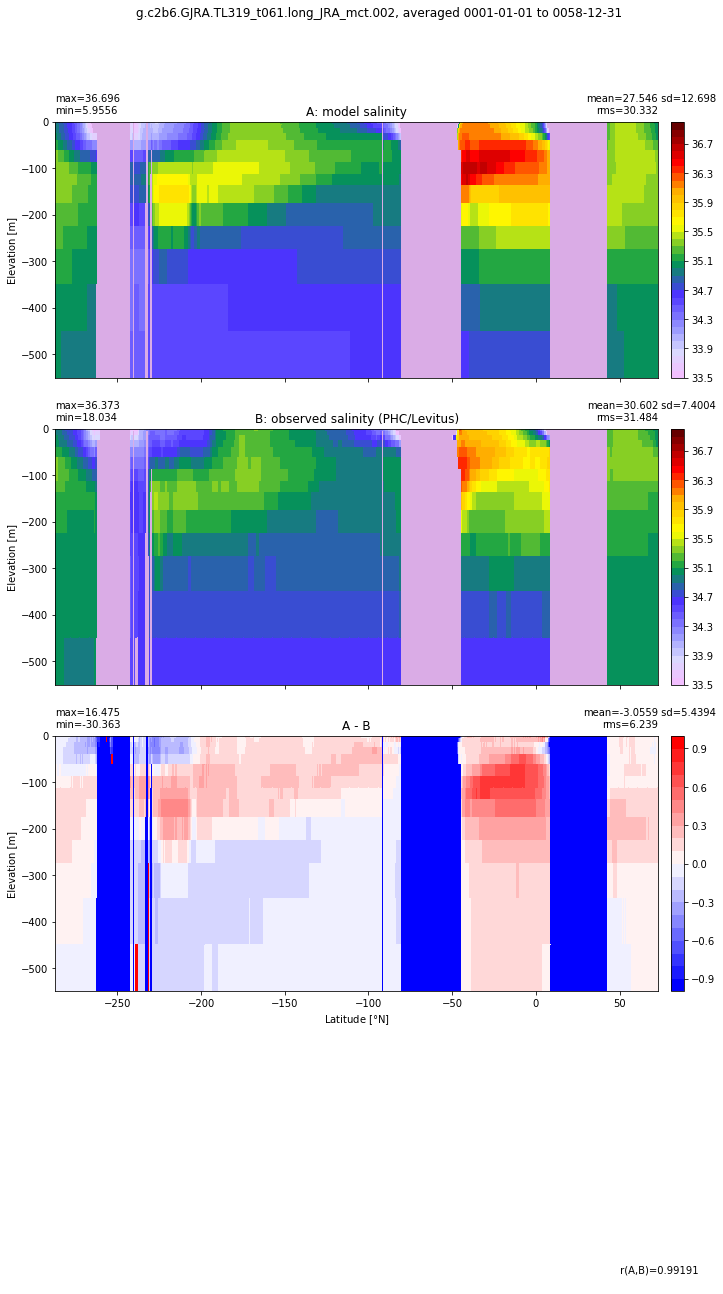

In [18]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,16))
yzcompare(salt_eq , salt_obs_eq, x, -Z,
        title1 = 'model salinity',
        title2 = 'observed salinity (PHC/Levitus)', axis=ax,
        suptitle=dcase.casename + ', averaged '+str(start_date)+ ' to ' +str(end_date),
        extend='neither', dextend='neither', clim=(33.5,37.), dlim=(-1,1), dcolormap=plt.cm.bwr)

(-400, 0)

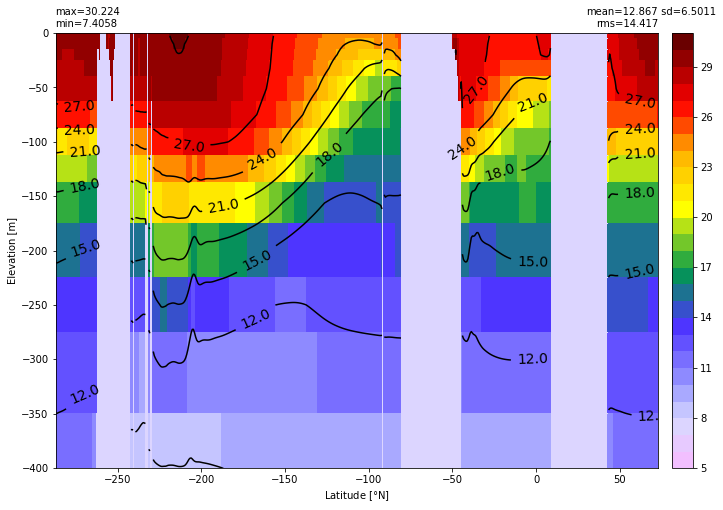

In [19]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
yzplot(temp_eq, x, -Z, axis=ax, clim=(5,31), landcolor=[0., 0., 0.], ignore=np.nan)
cs1 = ax.contour( x + 0*z, -z, temp_eq,  colors='k',); plt.clabel(cs1,fmt='%2.1f', fontsize=14)
plt.ylim(-400,0)

(-400, 0)

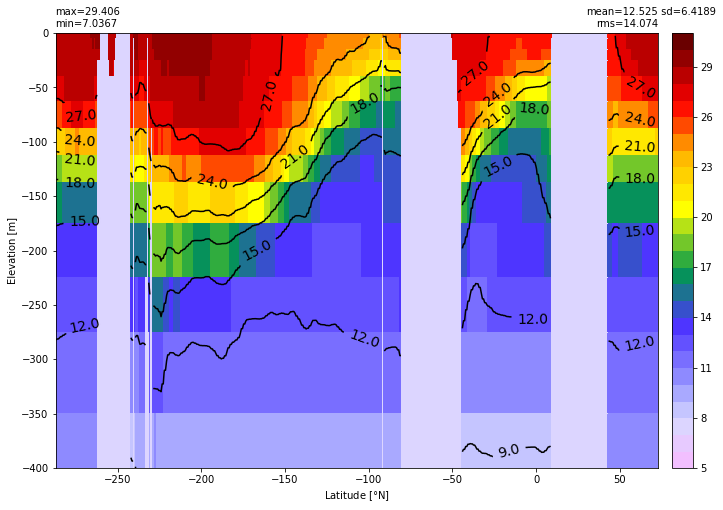

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
yzplot(thetao_obs_eq, x, -Z, axis=ax, clim=(5,31))
cs1 = ax.contour( x + 0*z, -z, thetao_obs_eq,  colors='k',); plt.clabel(cs1,fmt='%2.1f', fontsize=14)
ax.set_ylim(-400,0)

In [23]:
# Shift model data to compare against obs
tmp, lonh = shiftgrid(thetao.xh[-1].values, thetao[0,0,:].values, ds.thetao.xh.values)
tmp, lonq = shiftgrid(uo.xq[-1].values, uo[0,0,:].values, uo.xq.values)

thetao['xh'].values[:] = lonh
so['xh'].values[:] = lonh
uo['xq'].values[:] = lonq

In [24]:
# y and z from obs 
y_obs = johnson.YLAT11_101.values
zz = np.arange(0,510,10)
[Y, Z_obs] = np.meshgrid(y_obs, zz)
z_obs = 0.5 * ( Z_obs[0:-1,:] + Z_obs[1:,] )

In [25]:
# y and z from model
y_model = thetao.yh.values
z = eta.z_i.values
[Y, Z_model] = np.meshgrid(y_model, z)
z_model = 0.5 * ( Z_model[0:-1,:] + Z_model[1:,:] )

In [26]:
longitudes = [143., 156., 165., 180., 190., 205., 220., 235., 250., 265.]

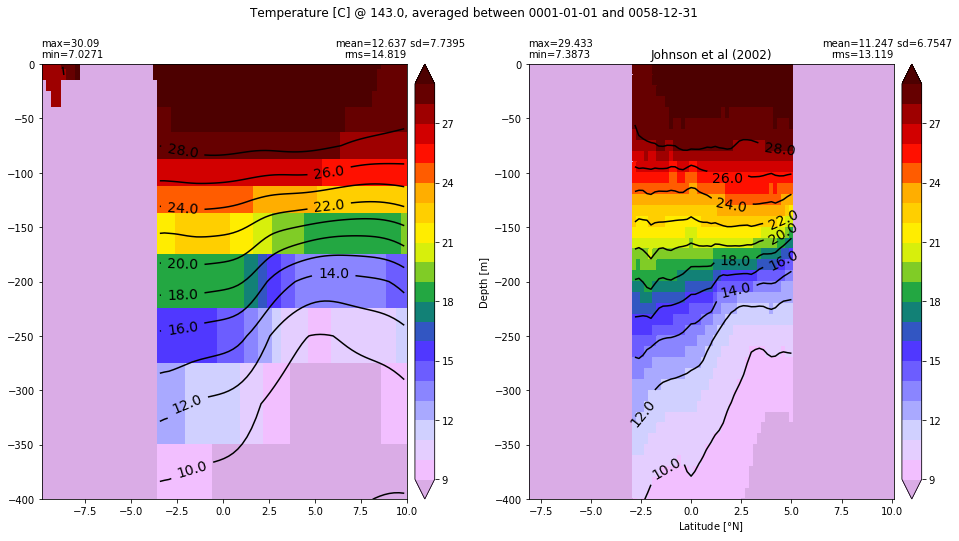

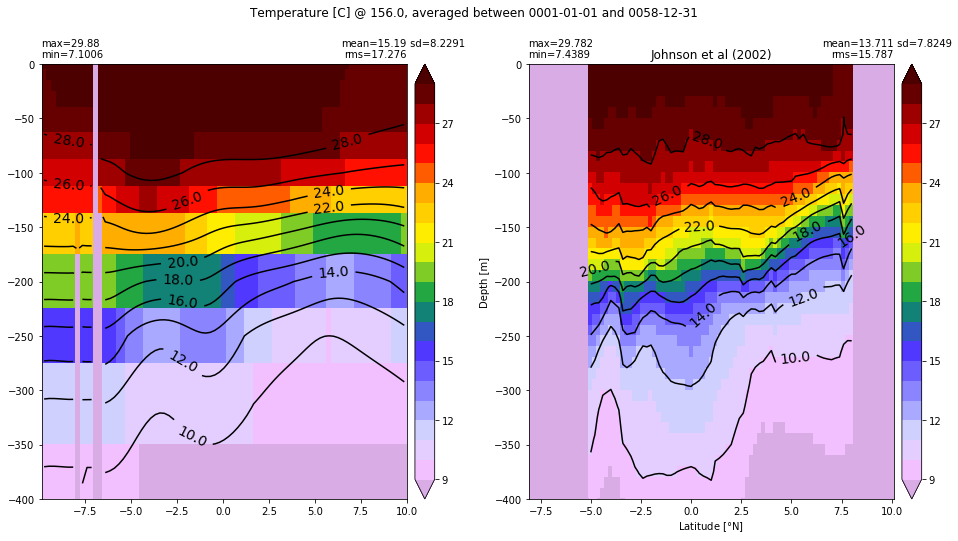

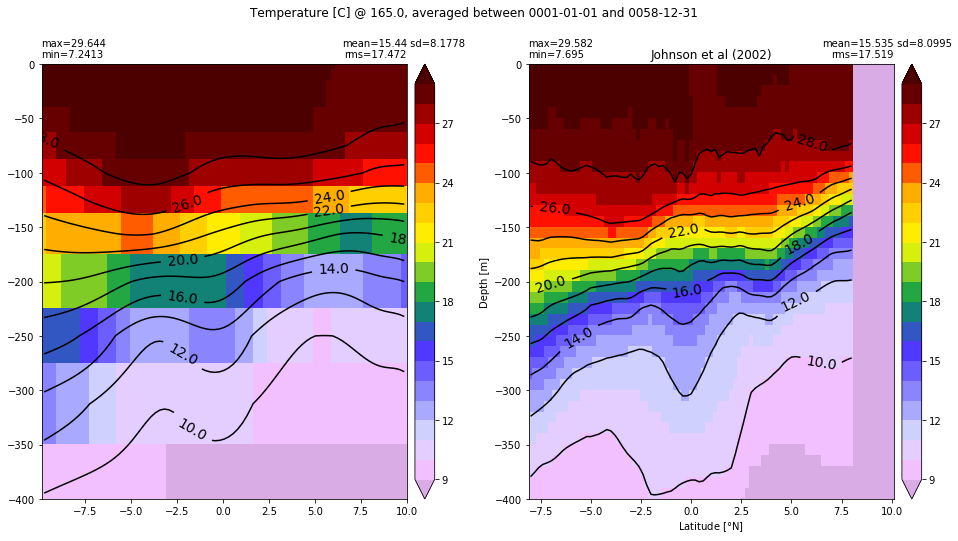

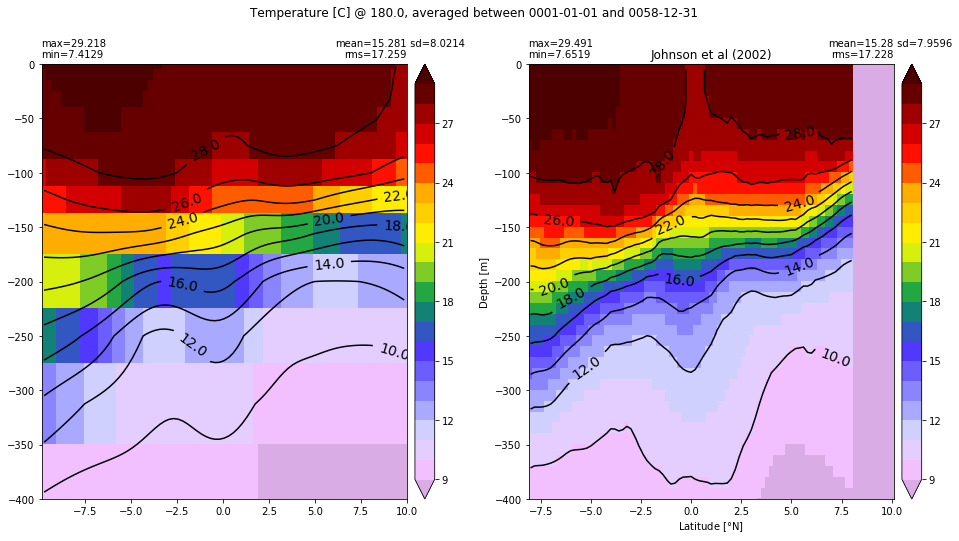

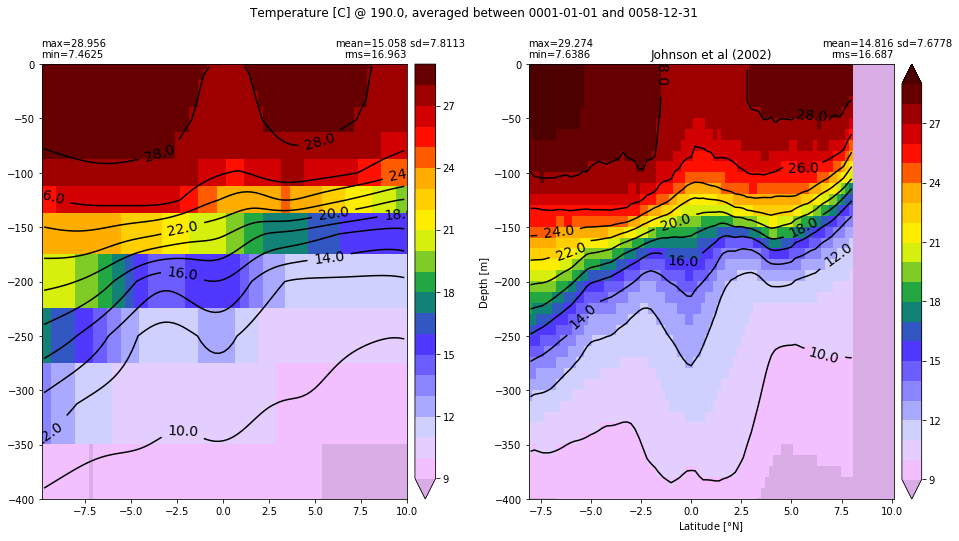

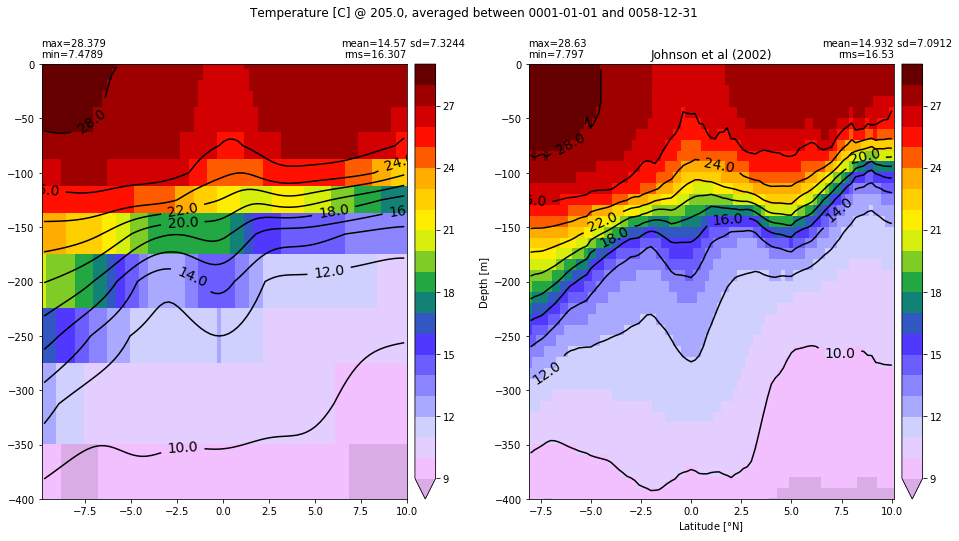

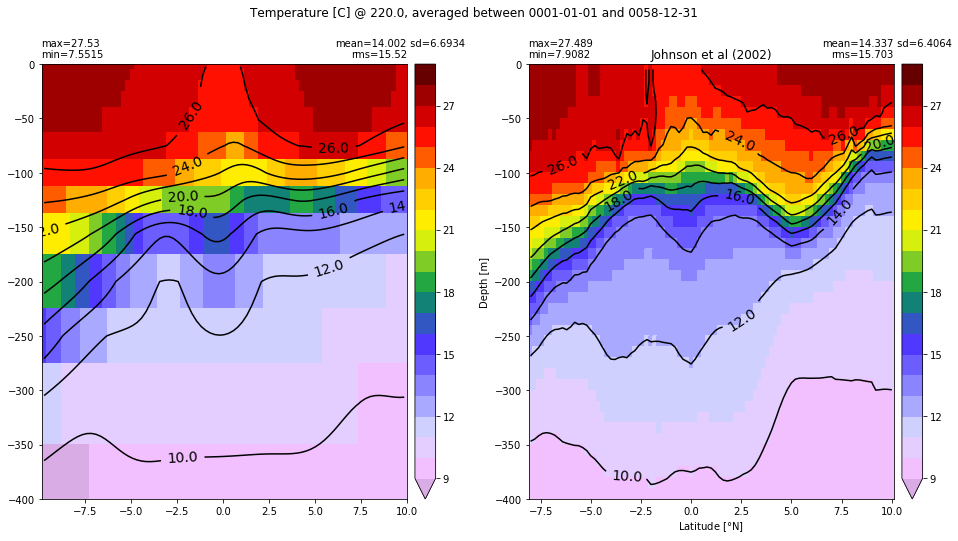

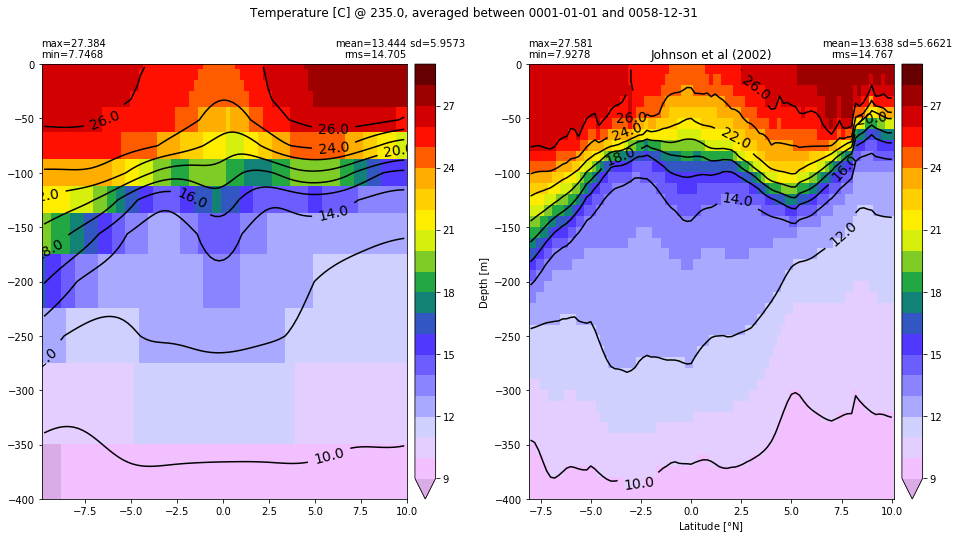

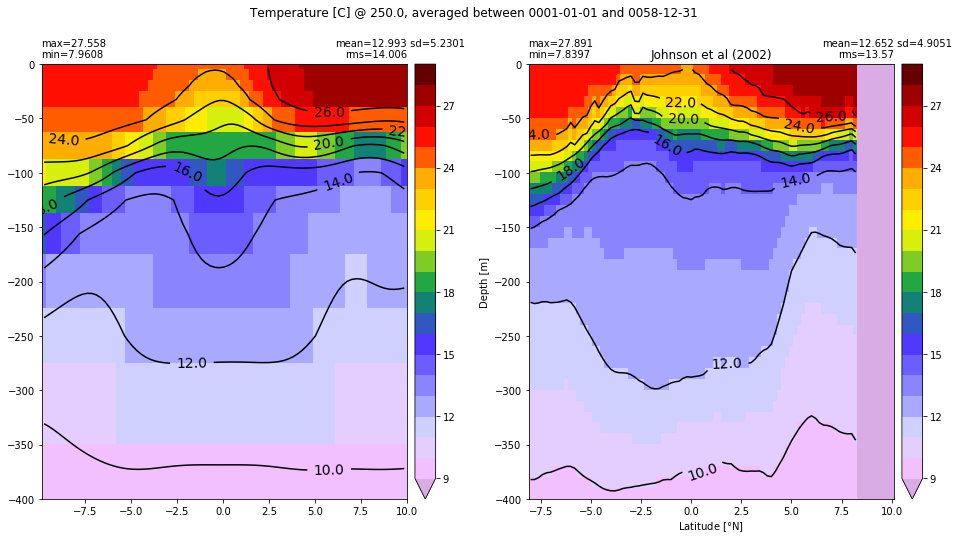

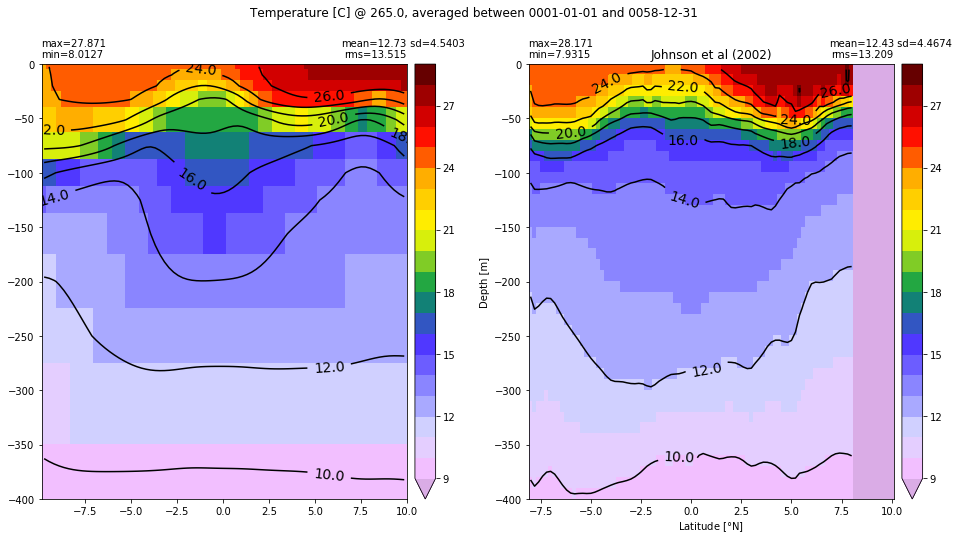

In [28]:
# Temperature
for l in longitudes:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    dummy_model = np.ma.masked_invalid(thetao.sel(xh=l, method='nearest').values)
    dummy_obs = np.ma.masked_invalid(johnson.POTEMPM.sel(XLON=l, method='nearest').values)
    yzplot(dummy_model, y_model, -Z_model, clim=(9,29), axis=ax1, zlabel='Depth', ylabel='Latitude', title=str(dcase.casename))
    cs1 = ax1.contour( y_model + 0*z_model, -z_model, dummy_model, levels=np.arange(0,30,2), colors='k',); plt.clabel(cs1,fmt='%3.1f', fontsize=14)
    ax1.set_ylim(-400,0)
    yzplot(dummy_obs, y_obs, -Z_obs, clim=(9,29), axis=ax2, zlabel='Depth', ylabel='Latitude', title='Johnson et al (2002)')
    cs2 = ax2.contour( y_obs + 0*z_obs, -z_obs, dummy_obs, levels=np.arange(0,30,2), colors='k',); plt.clabel(cs2,fmt='%3.1f', fontsize=14)
    ax2.set_ylim(-400,0)
    plt.suptitle('Temperature [C] @ '+str(l)+ ', averaged between '+str(start_date)+' and '+str(end_date))

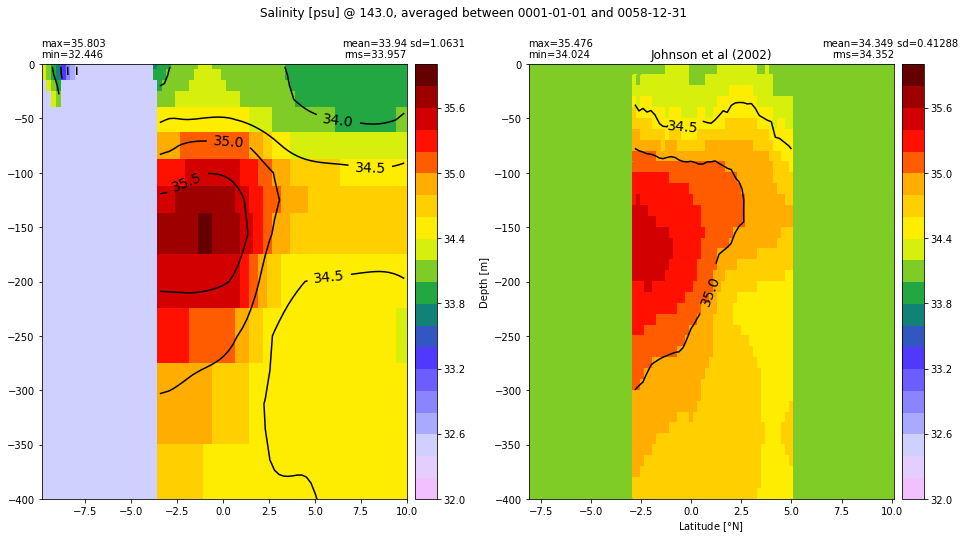

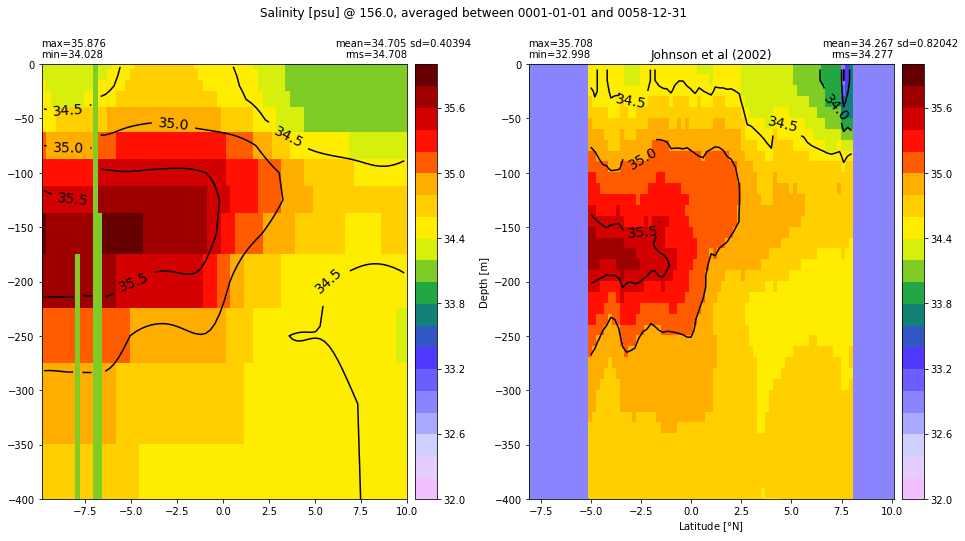

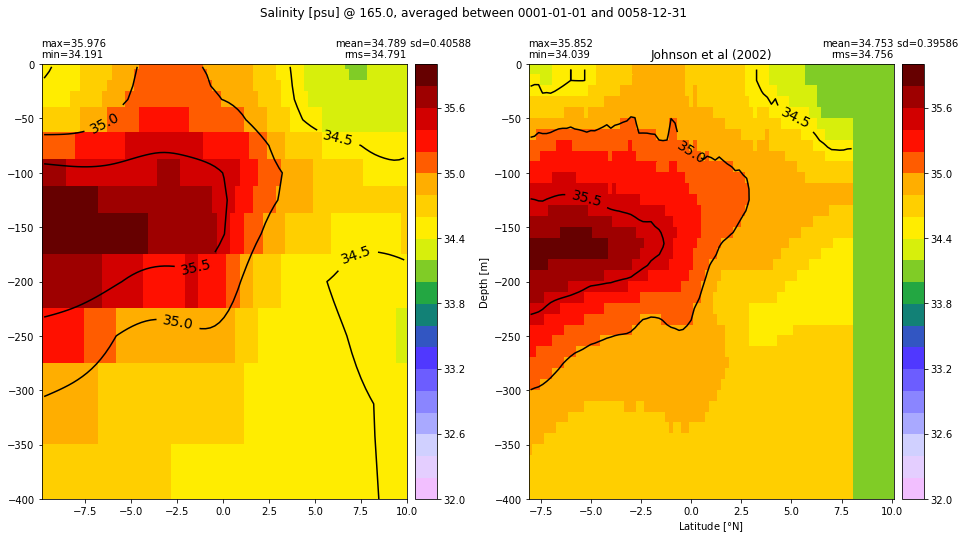

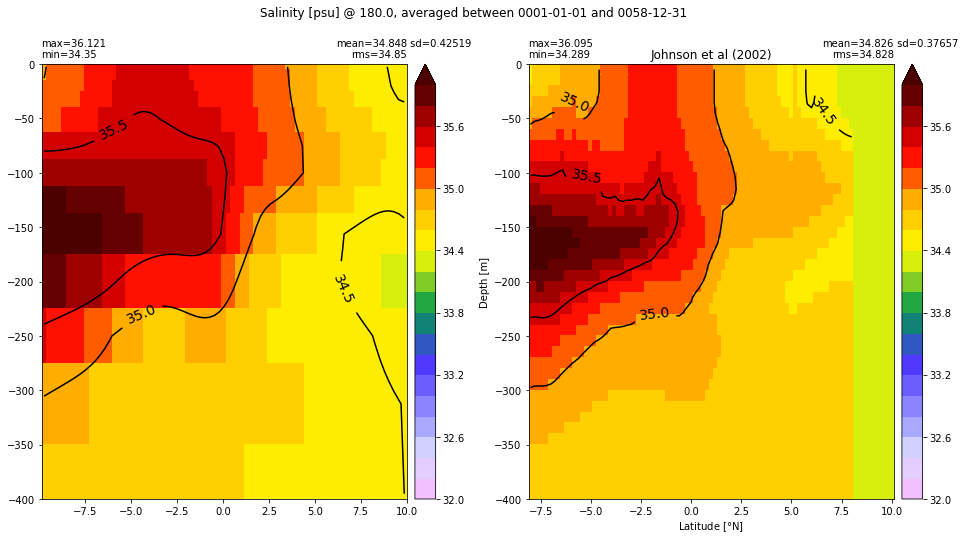

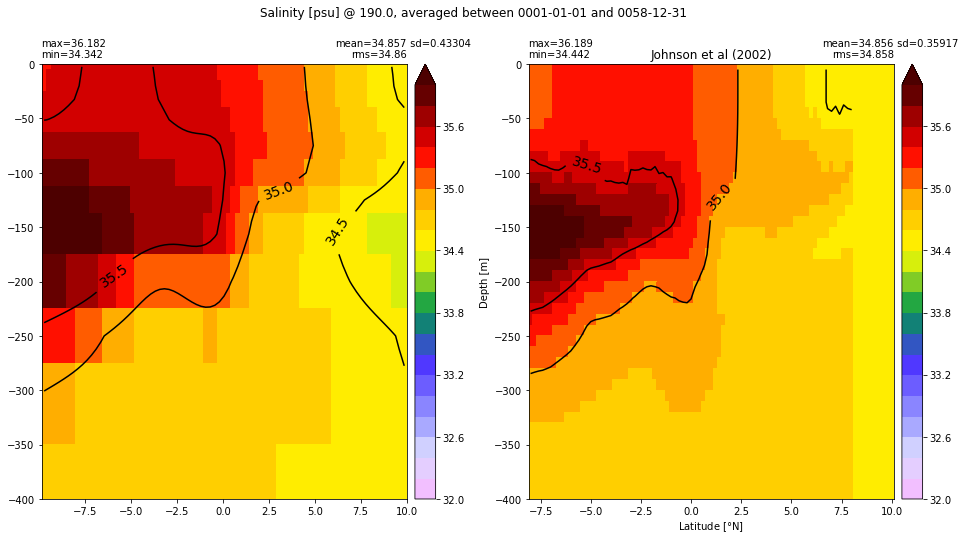

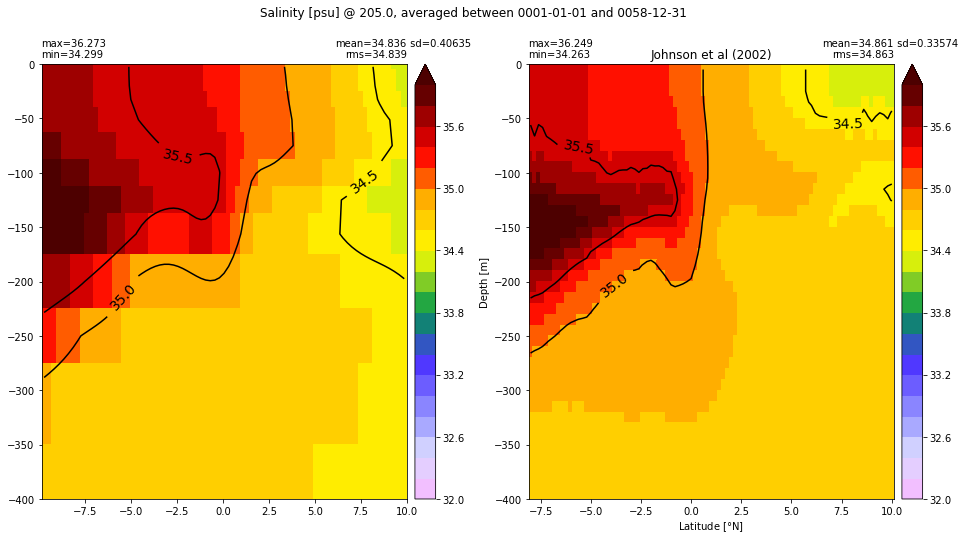

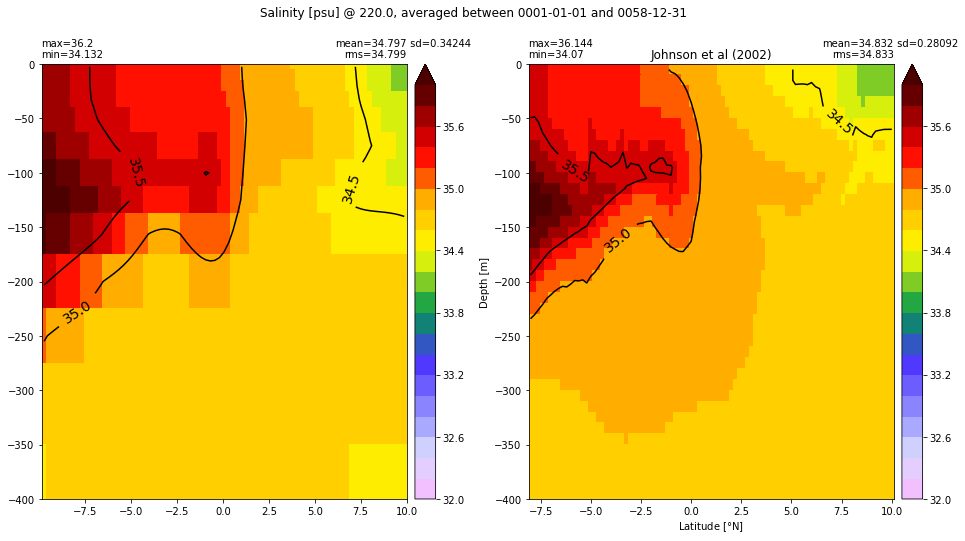

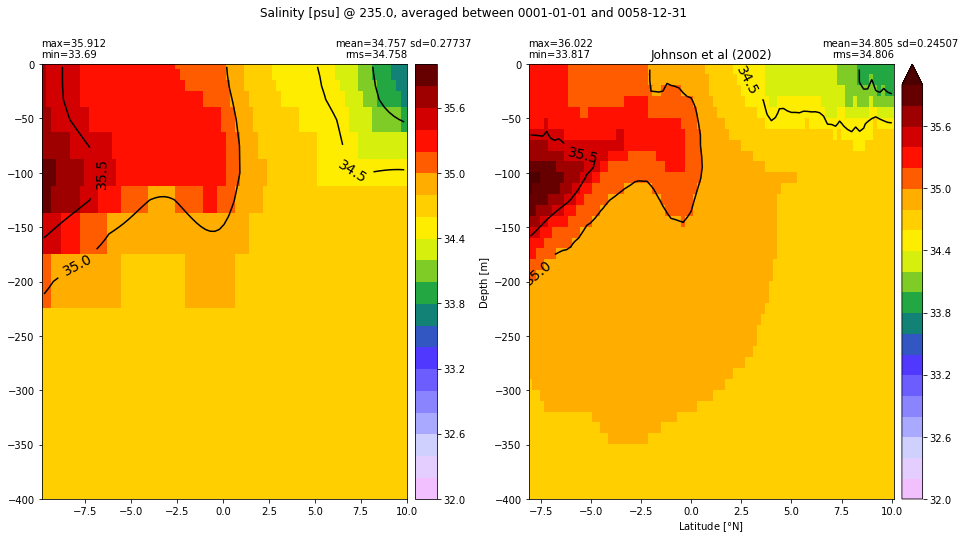

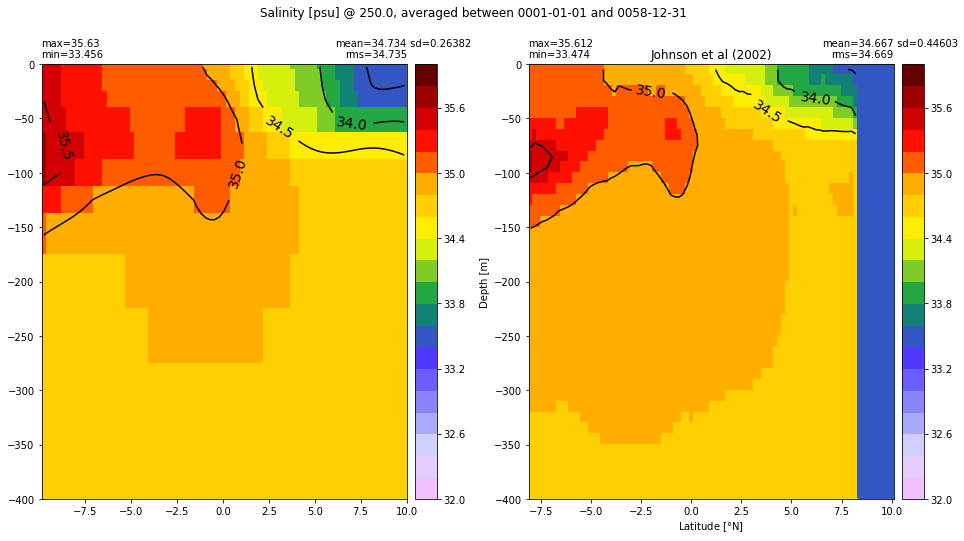

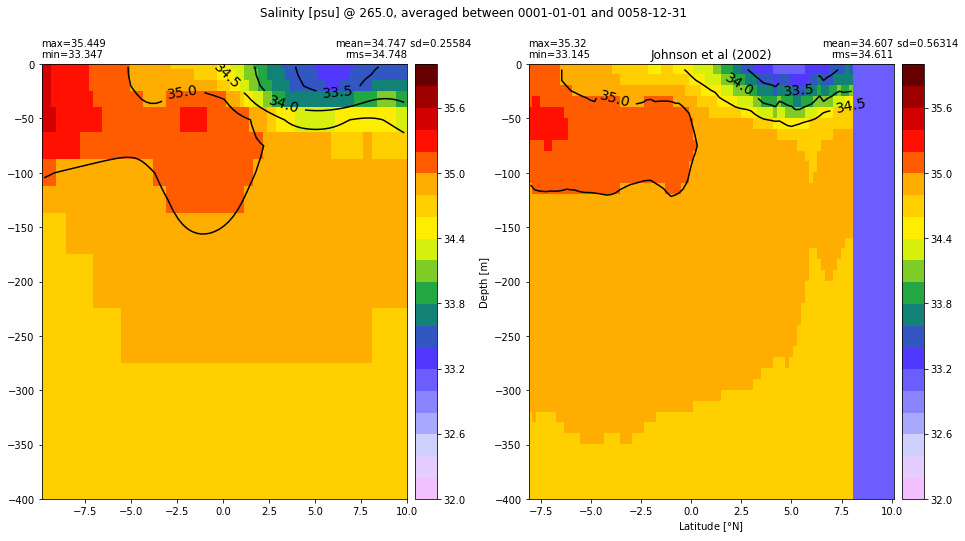

In [29]:
for l in longitudes:
    # Salt
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    dummy_model = np.ma.masked_invalid(so.sel(xh=l, method='nearest').values)
    dummy_obs = np.ma.masked_invalid(johnson.SALINITYM.sel(XLON=l, method='nearest').values)
    yzplot(dummy_model, y_model, -Z_model, clim=(32,36), axis=ax1, zlabel='Depth', ylabel='Latitude', title=str(dcase.casename))
    cs1 = ax1.contour( y_model + 0*z_model, -z_model, dummy_model, levels=np.arange(32,36,0.5), colors='k',); plt.clabel(cs1,fmt='%3.1f', fontsize=14)
    ax1.set_ylim(-400,0)
    yzplot(dummy_obs, y_obs, -Z_obs, clim=(32,36), axis=ax2, zlabel='Depth', ylabel='Latitude', title='Johnson et al (2002)')
    cs2 = ax2.contour( y_obs + 0*z_obs, -z_obs, dummy_obs, levels=np.arange(32,36,0.5), colors='k',); plt.clabel(cs2,fmt='%3.1f', fontsize=14)
    ax2.set_ylim(-400,0)
    plt.suptitle('Salinity [psu] @ '+str(l)+ ', averaged between '+str(start_date)+' and '+str(end_date))

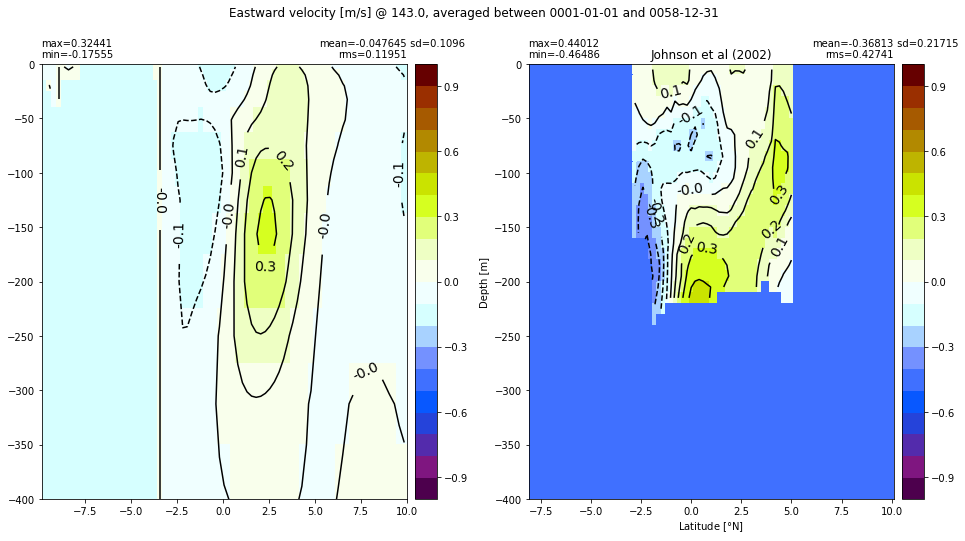

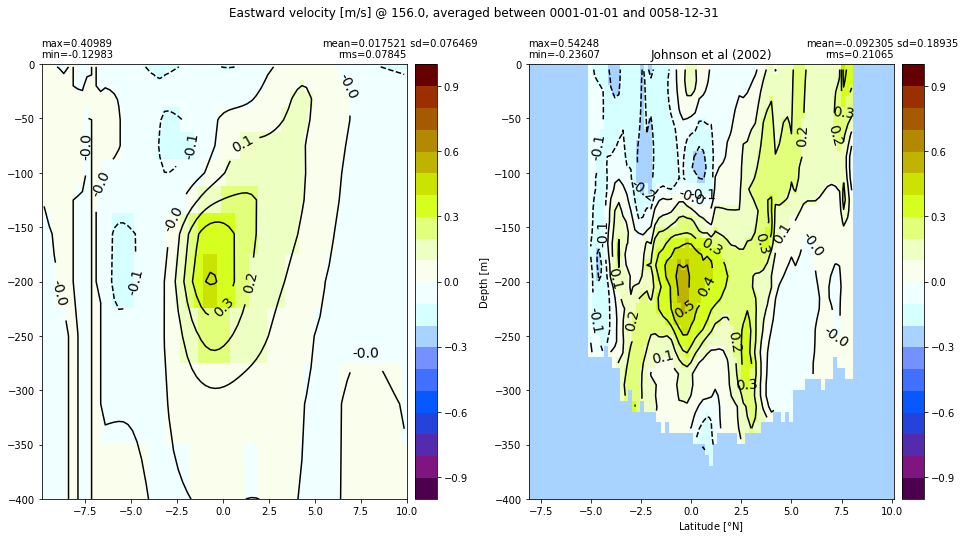

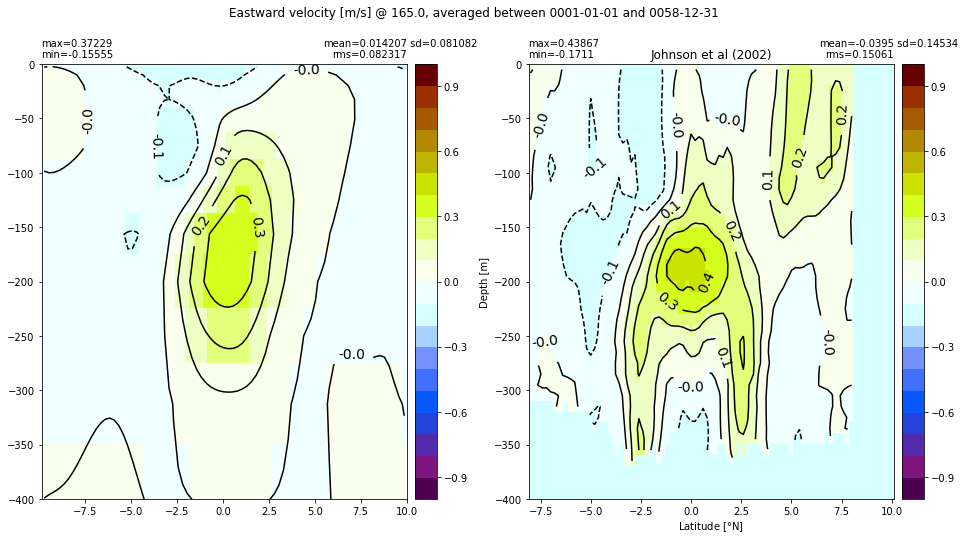

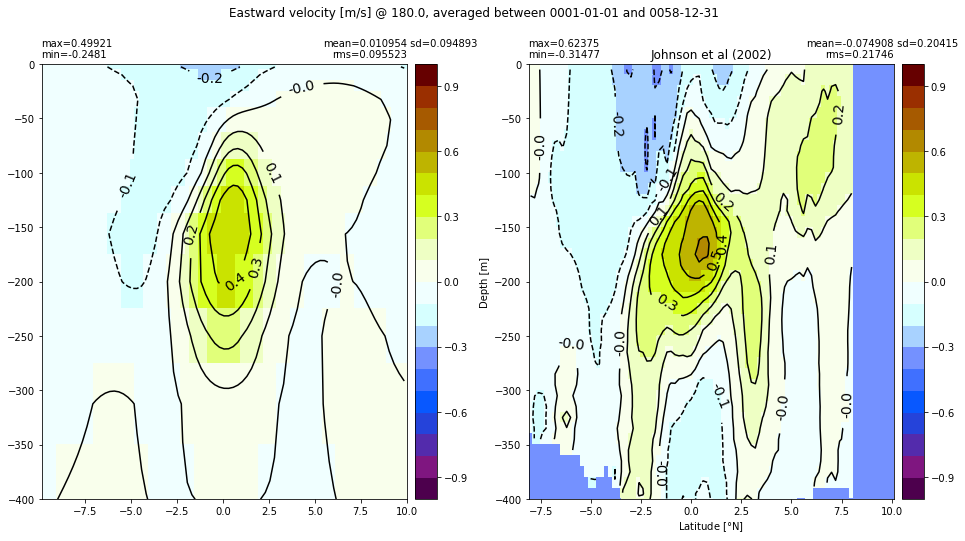

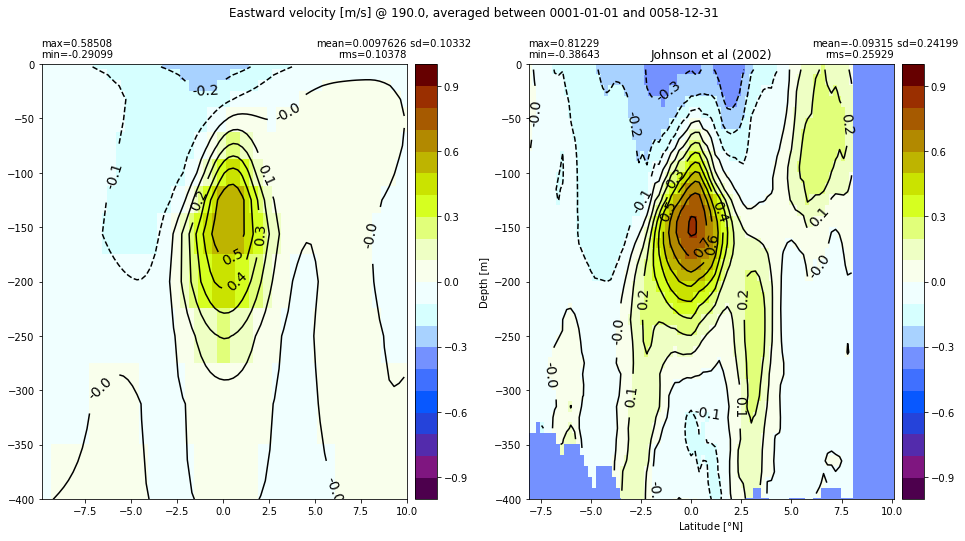

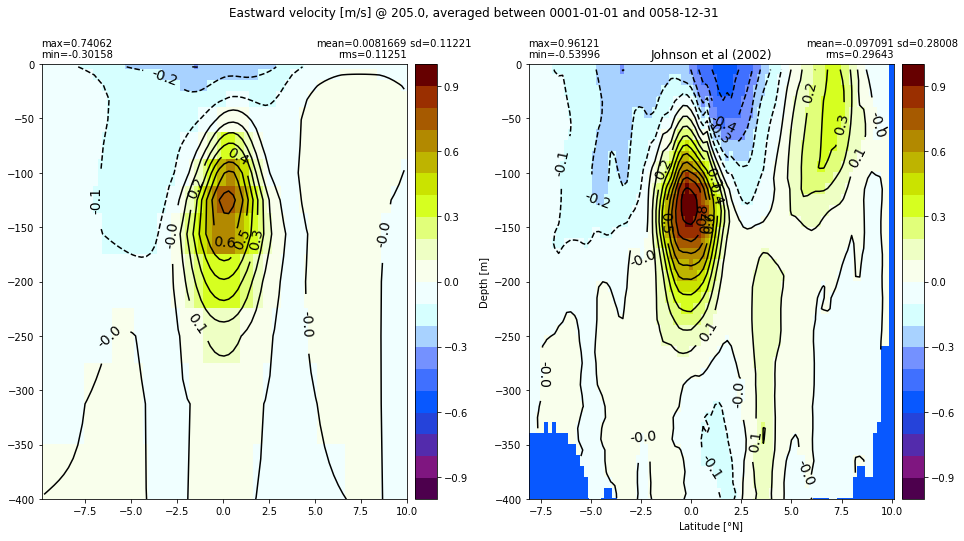

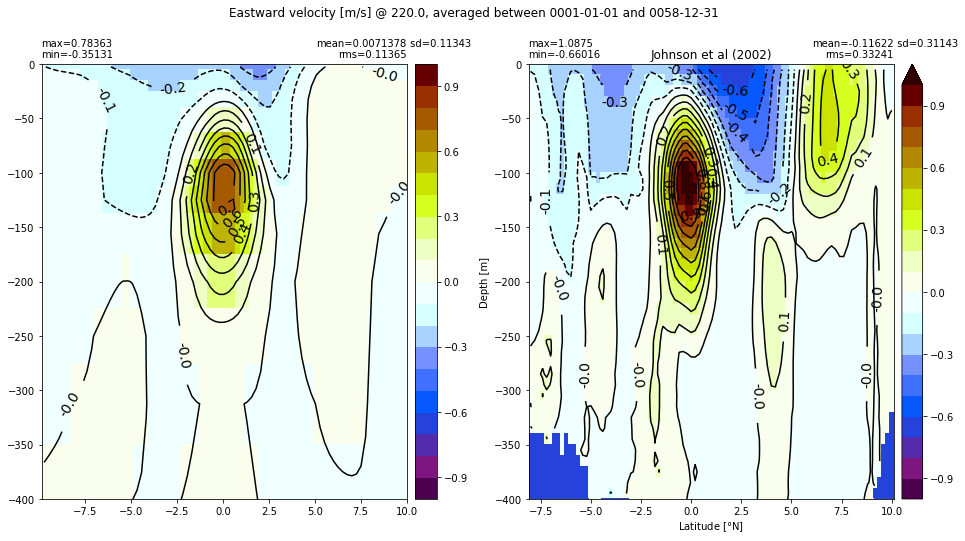

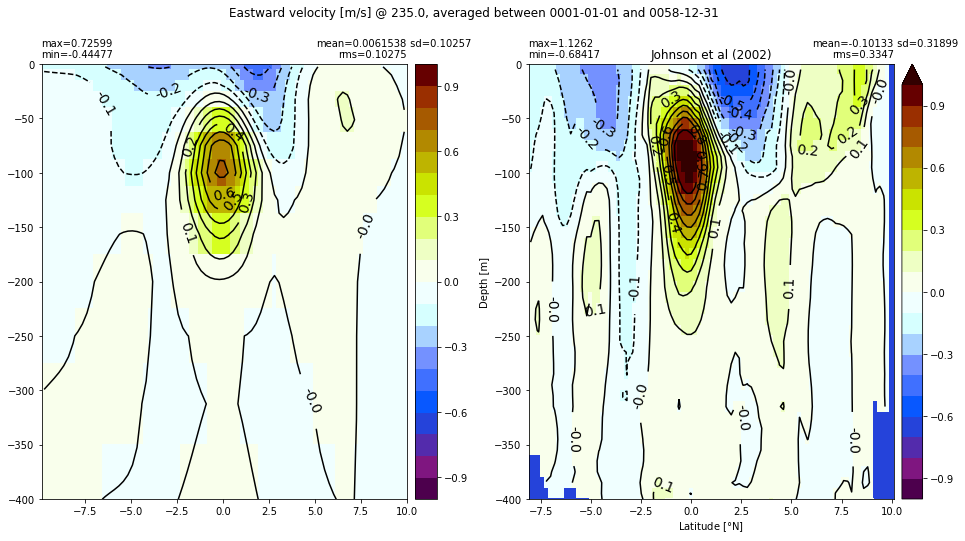

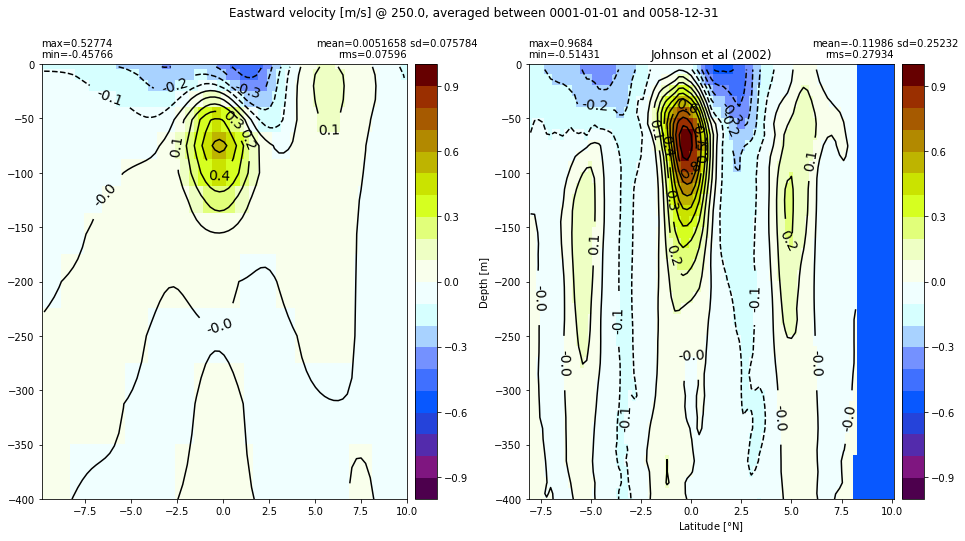

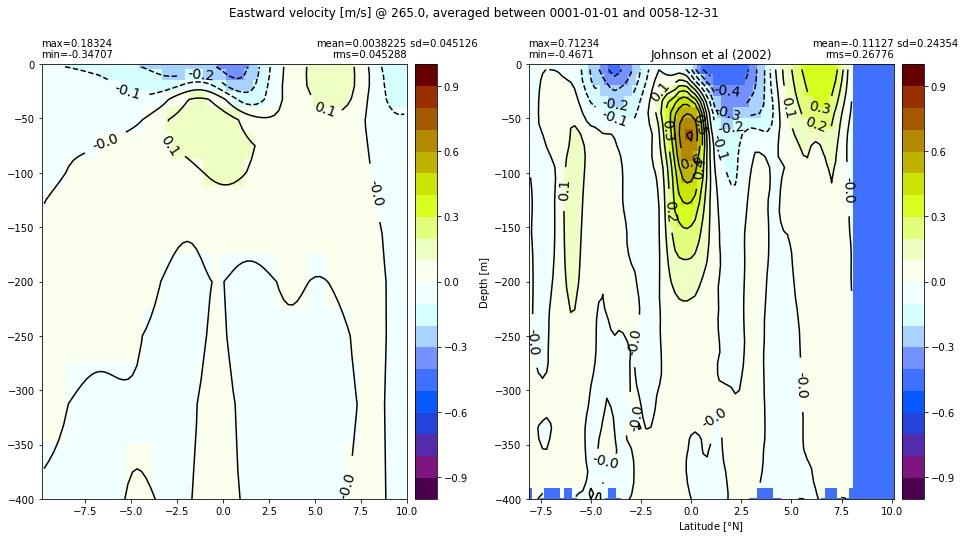

In [30]:
for l in longitudes:
    # uo
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    dummy_model = np.ma.masked_invalid(uo.sel(xq=l, method='nearest').values)
    dummy_obs = np.ma.masked_invalid(johnson.UM.sel(XLON=l, method='nearest').values)
    yzplot(dummy_model, y_model, -Z_model, clim=(-1,1), axis=ax1, zlabel='Depth', ylabel='Latitude', title=str(dcase.casename))
    cs1 = ax1.contour( y_model + 0*z_model, -z_model, dummy_model, levels=np.arange(-1,1,0.1), colors='k',); plt.clabel(cs1,fmt='%3.1f', fontsize=14)
    ax1.set_ylim(-400,0)
    yzplot(dummy_obs, y_obs, -Z_obs, clim=(-1,1), axis=ax2, zlabel='Depth', ylabel='Latitude', title='Johnson et al (2002)')
    cs2 = ax2.contour( y_obs + 0*z_obs, -z_obs, dummy_obs, levels=np.arange(-1,1,0.1), colors='k',); plt.clabel(cs2,fmt='%3.1f', fontsize=14)
    ax2.set_ylim(-400,0)
    plt.suptitle('Eastward velocity [m/s] @ '+str(l)+ ', averaged between '+str(start_date)+' and '+str(end_date))

In [36]:
x_obs = johnson.XLON.values
[X_obs, Z_obs] = np.meshgrid(x_obs, zz)
z_obs = 0.5 * ( Z_obs[:-1,:] + Z_obs[1:,:] )

In [69]:
x_model = so.xh.values
z = eta.z_i.values
[X, Z_model] = np.meshgrid(x_model, z)
z_model = 0.5 * ( Z_model[:-1,:] + Z_model[1:,:] )

Text(0.5, 0.98, 'Eastward velocity [m/s] along the Equatorial Pacific, averaged between 0001-01-01 and 0058-12-31')

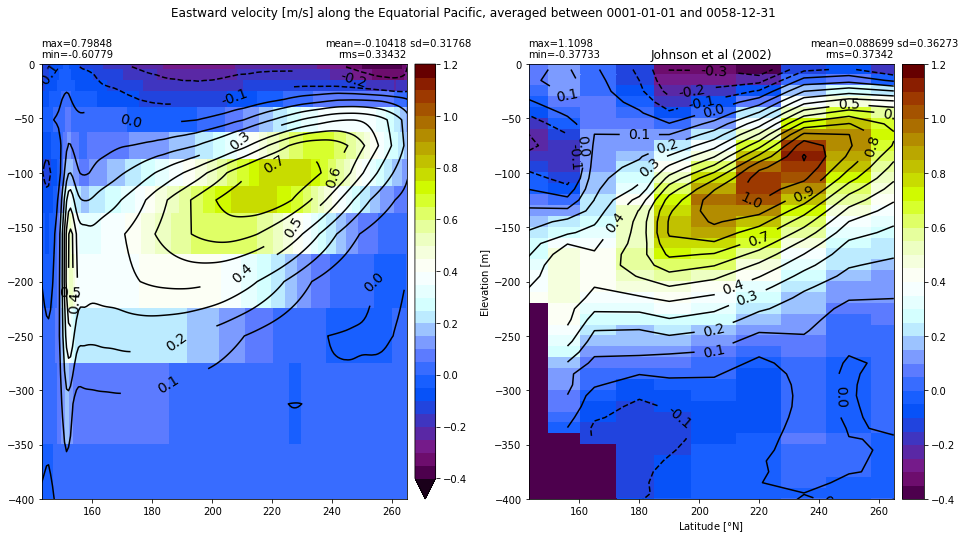

In [79]:
#from mom6_tools.m6plot import 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
dummy_obs = np.ma.masked_invalid(johnson.UM.sel(YLAT11_101=0).values)
dummy_model = np.ma.masked_invalid(uo.sel(yh=0, method='nearest').values)

yzplot(dummy_model, x_model, -Z_model, clim=(-0.4,1.2), axis=ax1, landcolor=[0., 0., 0.], title=str(dcase.casename))
cs1 = ax1.contour( x_model + 0*z_model, -z_model, dummy_model,  levels=np.arange(-1.2,1.2,0.1), colors='k',); plt.clabel(cs1,fmt='%2.1f', fontsize=14)
ax1.set_xlim(143,265); ax1.set_ylim(-400,0)
yzplot(dummy_obs, x_obs, -Z_obs, clim=(-0.4,1.2), axis=ax2, title='Johnson et al (2002)')
cs1 = ax2.contour( x_obs + 0*z_obs, -z_obs, dummy_obs,  levels=np.arange(-1.2,1.2,0.1), colors='k',); plt.clabel(cs1,fmt='%2.1f', fontsize=14)
ax2.set_xlim(143,265); ax2.set_ylim(-400,0)
plt.suptitle('Eastward velocity [m/s] along the Equatorial Pacific, averaged between '+str(start_date)+' and '+str(end_date))